In [23]:
import pandas as pd# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier


In [56]:
# Paths for train and test datasets
TRAIN_SET_PATH = '../data/raw/train.csv'
TEST_SET_PATH = '../data/raw/test.csv'
TRAIN_OUTPUT_PATH = '../data/processed/train_data_selected_engineered.csv'
TEST_OUTPUT_PATH = '../data/processed/test_data_selected_engineered.csv'

# Load the dataset
train_data = pd.read_csv(TRAIN_SET_PATH)
test_data = pd.read_csv(TEST_SET_PATH)

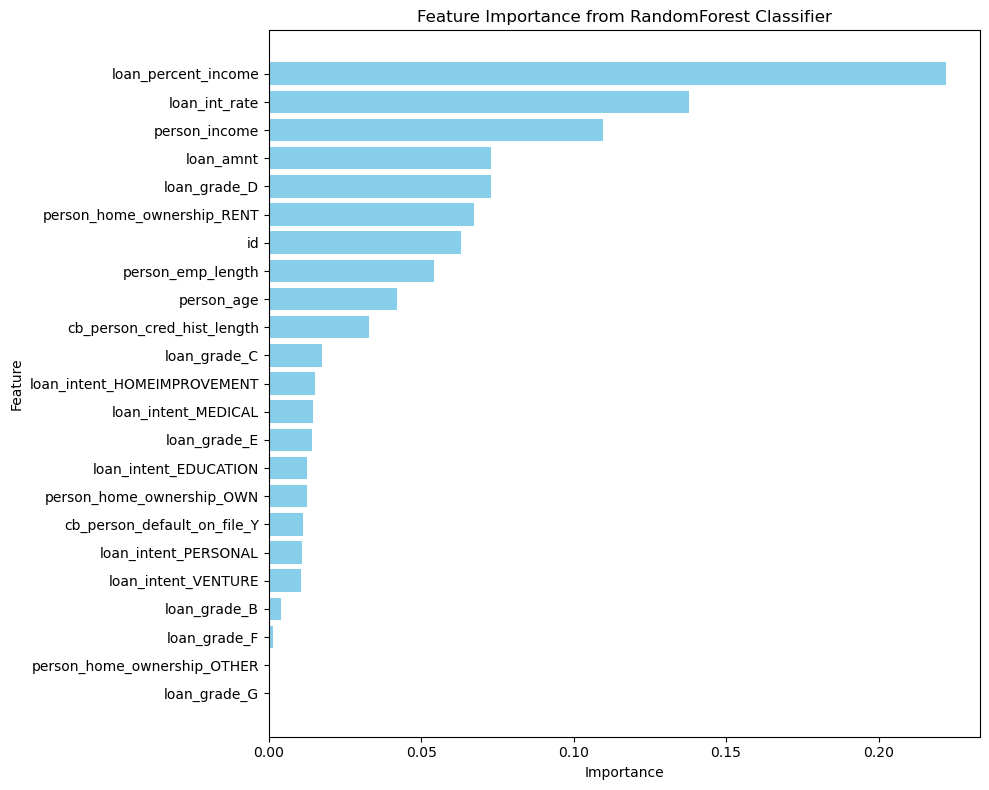

In [57]:
# Assuming 'loan_status' is the target variable
X = train_data.drop(columns=['loan_status'])
y = train_data['loan_status']

# Encode categorical variables if needed
X = pd.get_dummies(X, drop_first=True)

# Train a RandomForestClassifier to determine feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from RandomForest Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [65]:
# Function to preprocess both training and test datasets
def preprocess_dataset(file_path, output_file_path, is_training=True, train_columns=None, poly=None, interaction_features=None):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Encode categorical features
    data_encoded = pd.get_dummies(data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

    # Drop unnecessary features
    features_to_drop_encoded = [
        'id', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'loan_intent_HOMEIMPROVEMENT',
        'loan_intent_MEDICAL', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 
        'loan_intent_VENTURE', 'person_home_ownership_OTHER'
    ]
    data_encoded = data_encoded.drop(columns=features_to_drop_encoded, errors='ignore')

    # If preprocessing training data, perform feature engineering
    if is_training:
        # Feature Engineering - Create new features
        # 1. Create a financial stability index combining person_income, loan_amnt, and person_emp_length
        data_encoded['financial_stability_index'] = (
            data_encoded['person_income'] / (data_encoded['loan_amnt'] + 1)
        ) * data_encoded['person_emp_length']

        # 2. Create interaction features for important features
        interaction_features = ['loan_int_rate', 'loan_percent_income']
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        interaction_data = poly.fit_transform(data_encoded[interaction_features])
        interaction_feature_names = poly.get_feature_names_out(interaction_features)
        interaction_df = pd.DataFrame(interaction_data, columns=interaction_feature_names, index=data_encoded.index)

        # Drop existing interaction features if they are present to avoid duplicates
        data_encoded = data_encoded.drop(columns=[col for col in interaction_feature_names if col in data_encoded.columns], errors='ignore')

        # Concatenate interaction features with the original dataset
        data_encoded = pd.concat([data_encoded, interaction_df], axis=1)

        # Save the resulting dataset for further analysis
        data_encoded.to_csv(output_file_path, index=False)

        # Return columns and polynomial transformer for use in test set processing
        return data_encoded.columns.tolist(), poly, interaction_features

    else:
        # Ensure the test set has the same columns as the training set
        if train_columns is not None:
            missing_cols = [col for col in train_columns if col not in data_encoded.columns]
            for col in missing_cols:
                data_encoded[col] = 0
            data_encoded = data_encoded[train_columns]

        # Create financial stability index in the test set
        data_encoded['financial_stability_index'] = (
            data_encoded['person_income'] / (data_encoded['loan_amnt'] + 1)
        ) * data_encoded['person_emp_length']

        # Ensure interaction features are created for the test set
        if poly is not None and interaction_features is not None:
            interaction_data_test = poly.transform(data_encoded[interaction_features])
            interaction_feature_names = poly.get_feature_names_out(interaction_features)
            interaction_df_test = pd.DataFrame(interaction_data_test, columns=interaction_feature_names, index=data_encoded.index)

            # Drop existing interaction features if they are present to avoid duplicates
            data_encoded = data_encoded.drop(columns=[col for col in interaction_feature_names if col in data_encoded.columns], errors='ignore')

            # Concatenate interaction features with the test dataset
            data_encoded = pd.concat([data_encoded, interaction_df_test], axis=1)

        # Save the preprocessed test set
        data_encoded.to_csv(output_file_path, index=False)

# Example usage for training set:
train_columns, poly, interaction_features = preprocess_dataset(TRAIN_SET_PATH, TRAIN_OUTPUT_PATH, is_training=True)

# Example usage for test set:
preprocess_dataset(TEST_SET_PATH, TEST_OUTPUT_PATH, is_training=False, train_columns=train_columns, poly=poly, interaction_features=interaction_features)
